# 20210823_XGBRegressor_feature_selection
Going to try doing some feature selection now using techniques from Abishek Thakur's book.

---------
**Best to date**: From `20210810_XGBRegressor_tree_sweep2` I had found the following was the best result (RMSE = 7.89519 on the LB) thus far:

```python
model = XGBRegressor(
        tree_method='auto',
        booster='dart',
        n_estimators=400, 
        max_depth=3,
        learning_rate=0.1522, 
        subsample=1,
        random_state=42,
        n_jobs=-1, 
        verbosity=1, 
    )
```

Also found that `MaxAbsScaler` performed best, by a smidgen, prior to any feature selection.

**Baseline**: The "control" config for experiments as of today (20210823), yielding RMSE of `7.8619006924521` on an unaltered feature set:

```python
config_defaults = {
    "library": "xgboost",
    "tree_method": "auto", # set to 'gpu_hist' to try GPU if available
    "booster": 'gbtree', # dart may be marginally better, but will opt for this quicker approach as a default
    "n_estimators": 100, # a very low number -- optimal is probably 300ish -- but this will be quicker
    "max_depth": 3,
    "learning_rate": 0.1,
    "test_size": 0.2,
    "scaler": MaxAbsScaler # determined to be best with the above hyperparameters
}
```

In [1]:
baseline_rmse = 7.8619006924521

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold#, KFold
from sklearn.metrics import mean_squared_error
import wandb
from wandb.xgboost import wandb_callback
# import timm
from pathlib import Path
import os
import math
import seaborn as sns

# feature engineering tools
from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft


In [3]:
%matplotlib inline

In [4]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchinfo import summary
# # from fastai.callback.wandb import *
# from torch.cuda.amp import autocast, GradScaler

In [5]:
# from fastai.vision.all import *
from fastai.tabular.all import *
# from fastai.callback.wandb import WandbCallback

In [26]:
# import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MaxAbsScaler
# # from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier

In [27]:
# %env "WANDB_NOTEBOOK_NAME" "202108090846_XGBoostRegressor_tree_sweep"
os.environ['WANDB_NOTEBOOK_NAME'] = '20210824_XGBClassifier_feature_selection.ipynb'

In [8]:
config_run = {
    'name': os.environ['WANDB_NOTEBOOK_NAME'][:-6], # just removes the .ipynb extension, leaving the notebook filename's stem
    'tags': ['XGBoost', 'experimental', 'feature_selection'],
    'notes': "Going to try doing some feature selection now using techniques from Abishek Thakur's book.",
}

In [9]:
%config Completer.use_jedi = False

In [10]:
# set_seed(42, reproducible=True) # fastai only

In [11]:
datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/202108_august/')

In [12]:
# df = pd.read_csv(datapath/'train.csv', index_col='id', low_memory=False)
# df.index.name = None
# df.to_feather(path='./dataset_df.feather')
df = pd.read_feather(path='dataset_df.feather')
df.index.name = 'id'

In [1]:
df.isnull().sum().any() # False

NameError: name 'df' is not defined

In [14]:
# df.info(verbose=True, null_counts=True)

So no NaNs.

In [15]:
# df.describe()

In [16]:
y = df.loss

In [17]:
features = [x for x in df.columns if x != 'loss']

In [18]:
X = df[features]

# EDA

In [19]:
# for f in df.columns:
#     print(f + '\n-----------')
#     print(f"{f} max is {max(df[f])}")
#     print(f"{f} min is {min(df[f])}")

In [20]:
# for f in df.columns[:5]:
#     sns.scatterplot(data=df, x=f, y=y)

Scatterplots (and linear plots) don't seem very useful here -- the data is mostly quite widely distributed. 

In [21]:
len(X)

250000

In [22]:
df.head()

f0   f1        f2        f3          f4        f5        f6  \
id                                                                      
0  -0.002350   59  0.766739 -1.350460     42.2727  16.68570   30.3599   
1   0.784462  145 -0.463845 -0.530421  27324.9000   3.47545  160.4980   
2   0.317816   19 -0.432571 -0.382644   1383.2600  19.71290   31.1026   
3   0.210753   17 -0.616454  0.946362   -119.2530   4.08235  185.2570   
4   0.439671   20  0.968126 -0.092546     74.3020  12.30650   72.1860   

          f7         f8       f9  ...        f91        f92      f93  \
id                                ...                                  
0   1.267300   0.392007  1.09101  ...  -42.43990  26.854000  1.45751   
1   0.828007   3.735860  1.28138  ... -184.13200   7.901370  1.70644   
2  -0.515354  34.430800  1.24210  ...    7.43721  37.218100  3.25339   
3   1.383310 -47.521400  1.09130  ...    9.66778   0.626942  1.49425   
4  -0.233964  24.399100  1.10151  ...  290.65700  15.604300  1.73557   

         f94        f95       f96       f97      f98       f99  loss  
id                                                                    
0   0.696161   0.941764  1.828470  0.924090  2.29658  10.48980    15  
1  -0.494699  -2.058300  0.819184  0.439152  2.36470   1.14383     3  
2   0.337934   0.615037  2.216760  0.745268  1.69679  12.30550     6  
3   0.517513 -10.222100  2.627310  0.617270  1.45645  10.02880     2  
4  -0.476668   1.390190  2.195740  0.826987  1.78485   7.07197     1  

[5 rows x 101 columns]

In [23]:
len(y), len(y.value_counts())

(250000, 43)

So, it seems that we're actually looking at a classification problem here -- not a regression one.

Do we have any categorical features?

In [24]:
# len(X_train['f1'].unique())

NameError: name 'X_train' is not defined

In [ ]:
sns.histplot(x=X_train.columns, y=[len(X_train[f].unique()) for f in X_train.columns])    

It looks like we indeed do. 

In [ ]:
# possible_categoricals = {f: len(X_train[f].unique()) for f in X_train.columns if len(X_train[f].unique()) < 100000}
# possible_categoricals

# (todo) PCA

# (todo) TSNE
(See [[t-Distributed Stochastic Neighbor Embedding]] -- could try PCA too)

In [ ]:
from sklearn import manifold

In [ ]:
# tsne = manifold.TSNE(n_components=2, random_state=42)
# transformed_data = tsne.fit_transform(df.loss)

# Training Function

Here is a preliminary training function -- I'm allowing specification of a scaler at least for the time being.

In [32]:
config_defaults = {
    "library": "xgboost",
    "tree_method": "auto", # set to 'gpu_hist' to try GPU if available
    "booster": 'gbtree', # dart may be marginally better, but will opt for this quicker approach as a default
    "n_estimators": 100, # a very low number -- optimal is probably 300ish -- but this will be quicker
    "max_depth": 3,
    "learning_rate": 0.1,
    "test_size": 0.2,
    "scaler": MaxAbsScaler,
    'random_state': 42
}

In [29]:
def train(wandb_config):#, scaler): # passed in via config dict for now
    wandb.init(
        project="202108_Kaggle_tabular_playground",
        save_code=True,
        tags=config_run['tags'],
        name=config_run['name'],
        notes=config_run['notes'],
        config=wandb_config)
    
    config = wandb.config
        
    # applying hold-out before scaling
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config['test_size'], random_state=42)
    
    wandb.log({'scaler': MaxAbsScaler})
    s = MaxAbsScaler()
    X_train = s.fit_transform(X_train)
    X_valid = s.fit_transform(X_valid)
    
#     # instantiating the scaler and fitting it
#     if scaler:
#         s = scaler()
#         X_train = s.fit_transform(X_train)
#         X_valid = s.fit_transform(X_valid)
    
    model = XGBRegressor(
        tree_method=config.tree_method,
        booster=config.booster,
        n_estimators=config.n_estimators, 
        max_depth=config.max_depth,
        learning_rate=config.learning_rate, 
        test_size=config.test_size,
        subsample=1,
        random_state=42,
        n_jobs=-1, 
        verbosity=1, 
    )
    wandb.log({'params': model.get_params()})
    model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])
    y_preds = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_preds)
    rmse = math.sqrt(abs(mse))
    wandb.log({'mse':mse, 'rmse':rmse})
    print(f"MSE is {mse}\nRMSE is {rmse}")   
    wandb.finish()
    

# Weights & Biases Config
I'll wait to initialize the run, but here are some reasonable default configuration values that can also be used in instantiating models, etc. 
- Note that these are not *optimal* values -- they're chosen for speed more than performance.

In [ ]:
# config = {
#         "library": "xgboost",
#         "tree_method": "auto", # set to 'gpu_hist' to try GPU if available
#         "booster": 'gbtree',
#         "n_estimators": 100,
#         "max_depth": 3,
#         "learning_rate": 0.2,
#         "test_size": 0.2,
# #         "objective": "multi:softmax", # if using a classifier
#         "objective": 'reg:squarederror',
#         "subsample": 1,
#         "random_state": 42,
#     }

# Hold-out split
Per the discussion [here](https://www.kaggle.com/c/tabular-playground-series-aug-2021/discussion/262736), I'm going to split the data into training and validation sets here so as to avoid data leakage.

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config_defaults['test_size'], random_state=config_defaults['random_state'])

# Normalization

The dataset is not normalized -- it seems prudent to try it. As of 20210820, it seems that `StandardScaler` is vulnerable to outliers in a way that `MinMaxScaler` is not. Let's check for outliers.

Some options for visualizing the outliers include `seaborn` histograms or box plots, but `pandas` has a `hist` method that should suffice.

In [ ]:
# X_train.hist(bins=15, figsize=(30,30), layout=(20,5));

A few features have a nice pseudo-Gaussian distribution, but many have long tails (i.e. peak, usually on the left, then taper off for quite a ways), and a few seem to have several clusters (bimodal, but some with 3+ clusters). So that may be an argument against `StandardScaler`.

We can also just call `pandas.*describe` iteratively to get summary statistics:

In [ ]:
# for f in X_train.columns:
#     print("--------------------------\n")
#     print(X_train[f].describe())

We could slice into the `describe` generated `Series` to generate visualizations of the summary statistics.

In [ ]:
# summaries = X_train.describe()

In [ ]:
# summaries

In [ ]:
# for f in summaries.index:
#     summaries.loc[f].hist(bins=15, figsize=(30,30), ylabelsize=); #layout=(20,5));

# summaries.loc['mean'].hist(bins=15, figsize=(30,30),); #layout=(20,5));

In [ ]:
# summaries.loc['std'].hist(bins=15, figsize=(30,30),); #layout=(20,5));

So for both mean and standard deviation, there are a few outliers.

In [ ]:
# max(summaries.loc['mean'])

In [ ]:
# means = sorted(list(summaries.loc['mean']))
# stds = sorted(list(summaries.loc['std']))

In [ ]:
# means[:10], means[-11:]

In [ ]:
# stds[:10], stds[-10:]

So, we have one feature with 10-digit means and stds, one with 7-digit, two with 5-digit, and then six with 4-digit means and five with 4-digit stds. Which features are they, precisely?

In [ ]:
# summaries.loc['mean'].idxmax()

In [ ]:
# summaries.loc['std'].idxmax()

To identify more than just the biggest, use `pandas.*sort_values`

In [ ]:
# sorted_means = summaries.loc['mean'].sort_values()
# sorted_stds = summaries.loc['std'].sort_values()

In [ ]:
# sorted_means

In [ ]:
# sorted_stds

In [ ]:
# sorted_means[-12:], sorted_stds[-12:]

While `f52` and `f27` swap places in mean vs. std, the large values are, otherwise, the same.

All of this is to say, there is definitely good reason to do normalization here -- the scale of a few of the features is vastly different from that of other features. 
- Note that this is not to say that there are (or aren't) outliers *within* each features -- rather, it's simply noting that a few features are outliers wrt scale. 

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

## Scaling test

I think `RobustScaler` may be best, but let's try to do a little sweep experiment to confirm. I'll track each run for comparisons, but will *not* use the formal `wandb` sweep-tracking functionality.

In [ ]:
# for scaler in [StandardScaler, MaxAbsScaler, RobustScaler]: # omitting MinMax, as it performed worse than others
#     # opting for something quick here
#     train(config_defaults, scaler)

...Though, Abishek Thakur's book argues that tree models perform "fine" without normalization. Let's do a scaler-free run as a test. 

In [ ]:
# train(config_defaults, scaler=None)

Well, there *is* a tiny difference: the unnormalized data has a 0.00002 lower loss. So I'll scale.

At both `n_estimators=50` and `n_estimators=100`, the three remaining scalers perform identically wrt RMSE and (more or less) run time (with `StandardScaler` at 24sec, `RobustScaler` at 25sec, and the other at 26 sec). I'm inclined to try `RobustScaler` nonetheless, in case there are surprises in the test set.

**EDIT** ACTUALLY there *are* differences in their scores -- it's simply that `wandb` is rounding them away. In actuality, from lowest loss to highest:

- `MaxAbsScaler`: 7.8619006924521
- `RobustScaler`: 7.861971252500269
- `None`: 7.861994176720477
- `StandardScaler`: 7.862020066424922

So, `MaxAbsScaler` is the best choice (at least until I've generated additional features -- **should that happen first?**).

# Feature Selection

## Variance

In [ ]:
# Allow all rows of a Series or DataFrame, and all cols of a DataFrame, to be displayed
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [ ]:
# print(X_train.var()[:])

To ensure that you're not excluding things on account of the feature's magnitude, you should scale before you cut.

In [ ]:
# scaler = MaxAbsScaler()
# X_train_scaled = scaler.fit_transform(X_train) # outputs a numpy.ndarray, NOT a Pandas object

In [ ]:
# ?X_train_scaled

In [ ]:
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
# X_train_scaled_df.head()

In [ ]:
# print(pd.DataFrame(X_train_scaled_df).var().head())

In [ ]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', None)

In [ ]:
# print(pd.DataFrame(X_train_scaled_df).var().sort_values())

Let's try cutting out those features that fall below the 0.01 variance threshold post-normalization

In [34]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# wandb.init(
#     project="202108_Kaggle_tabular_playground",
#     save_code=True,
#     tags=config_run['tags'],
#     name=config_run['name'],
#     notes=config_run['notes'],
#     config=config_defaults)

# config = wandb.config

# # applying hold-out before scaling
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config['test_size'], random_state=42)

# # wandb.log({'scaler': MaxAbsScaler})
# s = MaxAbsScaler()
# X_train_s = s.fit_transform(X_train)
# X_valid_s = s.fit_transform(X_valid)

# # removing features with post-normalization variance <0.01
# var_thresh = VarianceThreshold(threshold=0.01)
# X_train_v = var_thresh.fit_transform(X_train_s)
# X_valid_v = var_thresh.fit_transform(X_valid_s)

# #     # instantiating the scaler and fitting it
# #     if scaler:
# #         s = scaler()
# #         X_train = s.fit_transform(X_train)
# #         X_valid = s.fit_transform(X_valid)

# model = XGBRegressor(
#     tree_method=config.tree_method,
#     booster=config.booster,
#     n_estimators=config.n_estimators, 
#     max_depth=config.max_depth,
#     learning_rate=config.learning_rate, 
#     test_size=config.test_size,
#     subsample=1,
#     random_state=42,
#     n_jobs=-1, 
#     verbosity=1, 
# )
# wandb.log({'params': model.get_params()})
# model.fit(X_train_v, y_train, callbacks=[wandb.xgboost.wandb_callback()])
# y_preds = model.predict(X_valid_v)
# mse = mean_squared_error(y_valid, y_preds)
# rmse = math.sqrt(abs(mse))
# wandb.log({'mse':mse, 'rmse':rmse})
# print(f"MSE is {mse}\nRMSE is {rmse}")   
# wandb.finish()
# if rmse < baseline_rmse:
#     print("RMSE is improved")
# else:
#     print("RMSE is not improved")

So that threshold didn't help. Let's try a more aggressive one.

In [ ]:
# wandb.init(
#     project="202108_Kaggle_tabular_playground",
#     save_code=True,
#     tags=config_run['tags'],
#     name=config_run['name'],
#     notes=config_run['notes'],
#     config=config_defaults)

# config = wandb.config

# # applying hold-out before scaling
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config['test_size'], random_state=42)

# # wandb.log({'scaler': MaxAbsScaler})
# s = MaxAbsScaler()
# X_train_s = s.fit_transform(X_train)
# X_valid_s = s.fit_transform(X_valid)

# # removing features with post-normalization variance <0.017
# var_thresh = VarianceThreshold(threshold=0.017)
# X_train_v = var_thresh.fit_transform(X_train_s)
# X_valid_v = var_thresh.fit_transform(X_valid_s)

# #     # instantiating the scaler and fitting it
# #     if scaler:
# #         s = scaler()
# #         X_train = s.fit_transform(X_train)
# #         X_valid = s.fit_transform(X_valid)

# model = XGBRegressor(
#     tree_method=config.tree_method,
#     booster=config.booster,
#     n_estimators=config.n_estimators, 
#     max_depth=config.max_depth,
#     learning_rate=config.learning_rate, 
#     test_size=config.test_size,
#     subsample=1,
#     random_state=42,
#     n_jobs=-1, 
#     verbosity=1, 
# )
# wandb.log({'params': model.get_params()})
# model.fit(X_train_v, y_train, callbacks=[wandb.xgboost.wandb_callback()])
# y_preds = model.predict(X_valid_v)
# mse = mean_squared_error(y_valid, y_preds)
# rmse = math.sqrt(abs(mse))
# wandb.log({'mse':mse, 'rmse':rmse})
# print(f"MSE is {mse}\nRMSE is {rmse}")   
# wandb.finish()
# if rmse < baseline_rmse:
#     print("RMSE is improved")
# else:
#     print("RMSE is not improved")

In [ ]:
# X_train_v.shape

In [ ]:
# X_valid_v.shape

So that's an interesting problem! A given threshold for the training set cuts off one more feature than it does for the validation set. Such, I suppose, is the peril of setting a variance threshold based on the pre-split data. Unfortunately, if you don't split before normalizing, you get a data leak -- and if you don't normalize before setting a variance threshold, you get spurious cuts. 

The solution, I suppose, is to only apply the variance threshold cut to the training set, and then manually subset the validation set's features on the basis of that cut.

In [ ]:
# wandb.log({"Crashed": True, "Crash explanation": "A given threshold for the training set cuts off one more feature than it does for the validation set. Such, I suppose, is the peril of setting a variance threshold based on the pre-split data. Unfortunately, if you don't split before normalizing, you get a data leak -- and if you don't normalize before setting a variance threshold, you get spurious cuts. The solution, I suppose, is to only apply the variance threshold cut to the training set, and then manually subset the validation set's features on the basis of that cut."})

In [ ]:
# wandb.finish()

In [ ]:
# wandb.init(
#     project="202108_Kaggle_tabular_playground",
#     save_code=True,
#     tags=config_run['tags'],
#     name=config_run['name'],
#     notes=config_run['notes'],
#     config=config_defaults)

# config = wandb.config

# # applying hold-out before scaling
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config['test_size'], random_state=42)

# # wandb.log({'scaler': MaxAbsScaler})
# s = MaxAbsScaler()
# X_train_s = s.fit_transform(X_train)
# X_valid_s = s.fit_transform(X_valid)

# # removing features with post-normalization variance <0.01
# var_thresh = VarianceThreshold(threshold=0.01)
# X_train_v = var_thresh.fit_transform(X_train_s)
# var_thresh.get_support()
# # X_train_v = pd.DataFrame(X_train_v)

In [ ]:
# X_train_v.shape

In [ ]:
# X_valid_s[:, var_thresh.get_support()].shape

In [ ]:
# X_valid_v = X_valid_s[:, var_thresh.get_support()]
# # X_valid_v = var_thresh.fit_transform(X_valid_s)

# #     # instantiating the scaler and fitting it
# #     if scaler:
# #         s = scaler()
# #         X_train = s.fit_transform(X_train)
# #         X_valid = s.fit_transform(X_valid)

# model = XGBRegressor(
#     tree_method=config.tree_method,
#     booster=config.booster,
#     n_estimators=config.n_estimators, 
#     max_depth=config.max_depth,
#     learning_rate=config.learning_rate, 
#     test_size=config.test_size,
#     subsample=1,
#     random_state=42,
#     n_jobs=-1, 
#     verbosity=1, 
# )
# wandb.log({'params': model.get_params()})
# model.fit(X_train_v, y_train, callbacks=[wandb.xgboost.wandb_callback()])
# y_preds = model.predict(X_valid_v)
# mse = mean_squared_error(y_valid, y_preds)
# rmse = math.sqrt(abs(mse))
# wandb.log({'mse':mse, 'rmse':rmse})
# print(f"MSE is {mse}\nRMSE is {rmse}")   
# wandb.finish()
# if rmse < baseline_rmse:
#     print("RMSE is improved")
# else:
#     print("RMSE is not improved")

In [ ]:
# wandb.init(
#     project="202108_Kaggle_tabular_playground",
#     save_code=True,
#     tags=config_run['tags'],
#     name=config_run['name'],
#     notes=config_run['notes'],
#     config=config_defaults)

# config = wandb.config

# # applying hold-out before scaling
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config['test_size'], random_state=42)

# # wandb.log({'scaler': MaxAbsScaler})
# s = MaxAbsScaler()
# X_train_s = s.fit_transform(X_train)
# X_valid_s = s.fit_transform(X_valid)

# # removing features with post-normalization variance <0.01
# var_thresh = VarianceThreshold(threshold=0.017)
# X_train_v = var_thresh.fit_transform(X_train_s)
# X_valid_v = X_valid_s[:, var_thresh.get_support()]
# # X_valid_v = var_thresh.fit_transform(X_valid_s)

# #     # instantiating the scaler and fitting it
# #     if scaler:
# #         s = scaler()
# #         X_train = s.fit_transform(X_train)
# #         X_valid = s.fit_transform(X_valid)

# model = XGBRegressor(
#     tree_method=config.tree_method,
#     booster=config.booster,
#     n_estimators=config.n_estimators, 
#     max_depth=config.max_depth,
#     learning_rate=config.learning_rate, 
#     test_size=config.test_size,
#     subsample=1,
#     random_state=42,
#     n_jobs=-1, 
#     verbosity=1, 
# )
# wandb.log({'params': model.get_params()})
# model.fit(X_train_v, y_train, callbacks=[wandb.xgboost.wandb_callback()])
# y_preds = model.predict(X_valid_v)
# mse = mean_squared_error(y_valid, y_preds)
# rmse = math.sqrt(abs(mse))
# wandb.log({'mse':mse, 'rmse':rmse})
# print(f"MSE is {mse}\nRMSE is {rmse}")   
# wandb.finish()
# if rmse < baseline_rmse:
#     print("RMSE is improved")
# else:
#     print("RMSE is not improved")

### Conclusion: Not worth it
So it appears that going by variance is a dead end. Properly implemented, it does *not* improve performance.

## Pearson's Correlation
Let's see if any features are highly correlated, and thus candidates for elimination (in the interest of getting rid of redundancies).

In [ ]:
# X_train_scaled_corr = X_train_scaled_df.corr()

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [ ]:
# X_train_scaled_corr

In [ ]:
# ?sns.heatmap

In [ ]:
# sns.heatmap(data=X_train_scaled_corr, annot=False, vmin=-1, vmax=1); # manually setting vmin and vmax since there are neg values

Looks like there's no real correlation at all...

In [ ]:
# sns.heatmap(data=X_train_scaled_corr.iloc[:50, :50], annot=False, vmin=-1, vmax=1);

In [ ]:
# sns.heatmap(data=X_train_scaled_corr.iloc[50:, 50:], annot=False, vmin=-1, vmax=1);

It increasingly seems like there may not be any truly useless or redundant features...

## (NOT WORKING) Wrapper for multiple techniques
Now, let's try writing a wrapper for a variety of techniques...

In [35]:
from sklearn.feature_selection import chi2, f_classif, f_regression, mutual_info_regression, SelectKBest, SelectPercentile

In [ ]:
# class UnivariateFeatureSelection:
#     def __init__(self, n_features, scoring):
#         """
#         Custom univariate feature selection wrapper, after Abishek Thakur's, 
#         for various sklearn scoring techniques. Could include a problem_type 
#         param too, but omitted for now.
#         :param n_features: SelectPercentile if float in range [0,1], else SelectKBest
#         :param scoring: scoring function, string
#         """
        
#         valid_scoring = {
#             "f_regression": f_regression,
#             "mutual_info_regression": mutual_info_regression
#         }
        
#         if scoring not in valid_scoring:
#             raise Exception("Invalid scoring function for a regression problem")
            
#         if isinstance(n_features, int):
#             self.selection = SelectKBest(
#             valid_scoring[scoring],
#             k=n_features)
#         elif isinstance(n_features, float):
#             self.selection = SelectPercentile(
#             valid_scoring[scoring],
#             percentile=int(n_features*100))
#         else:
#             raise Exception("Invalid type of feature")
            
#     def fit(self, X, y):
#         return self.selection.fit(X,y)
#     def transform(self,X):
#         return self.selection.transform(X)
#     def fit_transform(self,X,y):
#         return self.selection.fit_transform(X,y)
            

Now let's try it out, see if we can improve things at all. We'll redefine the train function accordingly.

### (NOT WORKING) Revised train function 

In [ ]:
# def train_feature_selection(model_config, n_f, fs):
#     wandb.init(
#         project="202108_Kaggle_tabular_playground",
#         save_code=True,
#         tags=config_run['tags'],
#         name=config_run['name'],
#         notes=config_run['notes'],
#         config=model_config)


#     # applying hold-out before scaling
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=model_config['test_size'], random_state=42)

# #     s = model_config['scaler']
# #     wandb.log({'scaler':s)
#     s = MaxAbsScaler()
#     X_train_s = s.fit_transform(X_train)
#     X_valid_s = s.fit_transform(X_valid)
#     #     X_train_s = s.fit_transform(x=X_train, y=y_train)
# #     X_valid_s = s.fit_transform(x=X_valid, y=y_valid)

#     # removing features with post-normalization variance <0.01
# #     var_thresh = VarianceThreshold(threshold=0.017)
# #     X_train_v = var_thresh.fit_transform(X_train_s)
# #     X_valid_v = X_valid_s[:, var_thresh.get_support()]
#     # X_valid_v = var_thresh.fit_transform(X_valid_s)

#     #     # instantiating the scaler and fitting it
#     #     if scaler:
#     #         s = scaler()
#     #         X_train = s.fit_transform(X_train)
#     #         X_valid = s.fit_transform(X_valid)

#     selector = SelectKBest(score_func='f_regression', k=90)
#     X_train_fs = selector.fit_tarnsform(X_train_s)
    
#     .fit(X_train_s, y_train)
#     X_train_t = ufs.transform(X_train_s)
#     X_valid_t = X_valid_s[:, ufs.get_support()]
    
#     model = XGBRegressor(
#         tree_method=config.tree_method,
#         booster=config.booster,
#         n_estimators=config.n_estimators, 
#         max_depth=config.max_depth,
#         learning_rate=config.learning_rate, 
#         test_size=config.test_size,
#         subsample=1,
#         random_state=42,
#         n_jobs=-1, 
#         verbosity=1, 
#     )
#     wandb.log({'params': model.get_params()})
#     model.fit(X_transformed, y_train, callbacks=[wandb.xgboost.wandb_callback()])
#     y_preds = model.predict(X_valid_t)
#     mse = mean_squared_error(y_valid, y_preds)
#     rmse = math.sqrt(abs(mse))
#     wandb.log({'mse':mse, 'rmse':rmse})
#     print(f"MSE is {mse}\nRMSE is {rmse}")   
#     wandb.finish()
# #     if rmse < baseline_rmse:
# #         print("RMSE is improved")
# #     else:
# #         print("RMSE is not improved")

In [ ]:
# train_feature_selection(model_config=config_defaults, fs='f_regression', n_f=0.1)

## f_regression
Not immediately able to get the wrapper working due to absence of a `get_support` method for the transforms (making it awkward to specify features for the validation set). Rather than do more of that right now, just going to try the feature selection methods it would have wrapped directly.

In [40]:
model_config = config_defaults 

wandb.init(
    project="202108_Kaggle_tabular_playground",
    save_code=True,
    tags=config_run['tags'],
    name=config_run['name'],
    notes=config_run['notes'],
    config=model_config)


# applying hold-out before scaling
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=model_config['test_size'], random_state=42)

#     s = model_config['scaler']
#     wandb.log({'scaler':s)
s = MaxAbsScaler()
X_train_s = s.fit_transform(X_train)
X_valid_s = s.fit_transform(X_valid)
#     X_train_s = s.fit_transform(x=X_train, y=y_train)
#     X_valid_s = s.fit_transform(x=X_valid, y=y_valid)

# removing features with post-normalization variance <0.01
#     var_thresh = VarianceThreshold(threshold=0.017)
#     X_train_v = var_thresh.fit_transform(X_train_s)
#     X_valid_v = X_valid_s[:, var_thresh.get_support()]
# X_valid_v = var_thresh.fit_transform(X_valid_s)

#     # instantiating the scaler and fitting it
#     if scaler:
#         s = scaler()
#         X_train = s.fit_transform(X_train)
#         X_valid = s.fit_transform(X_valid)

selector = SelectKBest(score_func=f_regression, k=90)
X_train_fs = selector.fit_transform(X_train_s, y_train)

In [43]:
X_valid_fs = X_valid_s[:, selector.get_support()]

model = XGBRegressor(
    tree_method=config_defaults['tree_method'],
    booster=config_defaults['booster'],
    n_estimators=config_defaults['n_estimators'], 
    max_depth=config_defaults['max_depth'],
    learning_rate=config_defaults['learning_rate'], 
    test_size=config_defaults['test_size'],
    subsample=1,
    random_state=config_defaults['random_state'],
    n_jobs=-1, 
    verbosity=1, 
)
wandb.log({'params': model.get_params()})
model.fit(X_train_fs, y_train, callbacks=[wandb.xgboost.wandb_callback()])
y_preds = model.predict(X_valid_fs)
mse = mean_squared_error(y_valid, y_preds)
rmse = math.sqrt(abs(mse))
wandb.log({'mse':mse, 'rmse':rmse})
print(f"MSE is {mse}\nRMSE is {rmse}")   
wandb.finish()
#     if rmse < baseline_rmse:
#         print("RMSE is improved")
#     else:
#         print("RMSE is not improved")    
    
# selector = SelectKBest(score_func='f_regression', k=90)
# X_train_fs = selector.fit_tarnsform(X_train_s)

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[08:56:31] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.80036663884677
RMSE is 7.861320922010929


In [44]:
rmse < baseline_rmse

True

So we finally have improvement! Selecting the k=90 best features yields an improvement (RMSE = 7.861320922010929). I think it's worth doing a sweep here to determine the optimal number of features to use.

### Sweep for f_regression scored feature selection

In [45]:
def train_fs(k, model_config=config_defaults):
    wandb.init(
        project="202108_Kaggle_tabular_playground",
        save_code=True,
        tags=config_run['tags'],
        name=config_run['name'],
        notes=config_run['notes'],
        config=model_config)


    # applying hold-out before scaling
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=model_config['test_size'], random_state=42)

    #     s = model_config['scaler']
    #     wandb.log({'scaler':s)
    s = MaxAbsScaler()
    X_train_s = s.fit_transform(X_train)
    X_valid_s = s.fit_transform(X_valid)
    #     X_train_s = s.fit_transform(x=X_train, y=y_train)
    #     X_valid_s = s.fit_transform(x=X_valid, y=y_valid)

    # removing features with post-normalization variance <0.01
    #     var_thresh = VarianceThreshold(threshold=0.017)
    #     X_train_v = var_thresh.fit_transform(X_train_s)
    #     X_valid_v = X_valid_s[:, var_thresh.get_support()]
    # X_valid_v = var_thresh.fit_transform(X_valid_s)

    #     # instantiating the scaler and fitting it
    #     if scaler:
    #         s = scaler()
    #         X_train = s.fit_transform(X_train)
    #         X_valid = s.fit_transform(X_valid)

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_fs = selector.fit_transform(X_train_s, y_train)
    X_valid_fs = X_valid_s[:, selector.get_support()]

    model = XGBRegressor(
        tree_method=config_defaults['tree_method'],
        booster=config_defaults['booster'],
        n_estimators=config_defaults['n_estimators'], 
        max_depth=config_defaults['max_depth'],
        learning_rate=config_defaults['learning_rate'], 
        test_size=config_defaults['test_size'],
        subsample=1,
        random_state=config_defaults['random_state'],
        n_jobs=-1, 
        verbosity=1, 
    )
    wandb.log({'params': model.get_params()})
    model.fit(X_train_fs, y_train, callbacks=[wandb.xgboost.wandb_callback()])
    y_preds = model.predict(X_valid_fs)
    mse = mean_squared_error(y_valid, y_preds)
    rmse = math.sqrt(abs(mse))
    wandb.log({'mse':mse, 'rmse':rmse, 'kbest':k})
    print(f"MSE is {mse}\nRMSE is {rmse} with {k}-best features.")
    wandb.finish()
    #     if rmse < baseline_rmse:
    #         print("RMSE is improved")
    #     else:
    #         print("RMSE is not improved")    

    # selector = SelectKBest(score_func='f_regression', k=90)
    # X_train_fs = selector.fit_tarnsform(X_train_s)

In [47]:
# for k in range(60,100):
#     train_fs(k)

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:48:04] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.82351624074679
RMSE is 7.862793157698274 with 60-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:48:24] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.819060168731724
RMSE is 7.8625097881485475 with 61-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:48:44] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.83122021349073
RMSE is 7.863283042946549 with 62-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:49:05] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.83173361441157
RMSE is 7.863315688334761 with 63-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:49:26] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.82364857012101
RMSE is 7.862801572602542 with 64-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:49:46] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.826746831514214
RMSE is 7.862998590328896 with 65-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:50:07] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.83048268911119
RMSE is 7.863236146085859 with 66-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:50:31] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE is 61.82803843145165
RMSE is 7.863080721412674 with 67-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:50:53] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.827963056673205
RMSE is 7.863075928456573 with 68-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:51:13] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.827963056673205
RMSE is 7.863075928456573 with 69-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:51:35] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.828063757794474
RMSE is 7.863082331871801 with 70-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:51:58] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.826899851358206
RMSE is 7.863008320697506 with 71-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:52:20] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE is 61.80001652808099
RMSE is 7.861298654044444 with 72-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:52:41] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.79656149778224
RMSE is 7.861078901638264 with 73-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:53:04] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.804757328338205
RMSE is 7.861600176067097 with 74-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:53:26] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.804757328338205
RMSE is 7.861600176067097 with 75-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:53:48] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.79897830134793
RMSE is 7.861232619719883 with 76-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:54:10] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.794522141365974
RMSE is 7.860949188321088 with 77-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:54:32] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.78623088462622
RMSE is 7.860421800681324 with 78-best features.


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[09:54:54] WARNING: ../src/learner.cc:573: 
Parameters: { "test_size" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.78431463849024
RMSE is 7.860299907668297 with 79-best features.


There's a local minimum for the RMSE loss at k=79 and k=80 (both of which come back with `7.860299907668297`).

## (todo) Mutual Information (MI)


In [16]:
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc(
#     "axes",
#     labelweight="bold",
#     labelsize="large",
#     titleweight="bold",
#     titlesize=14,
#     titlepad=10,
# )

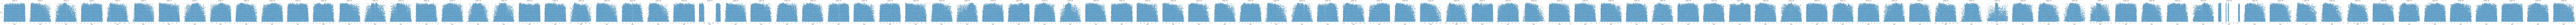

In [30]:
# sns.relplot(x="value", y="loss", col="variable", data=df.melt(id_vars="loss", value_vars=features), facet_kws=dict(sharex=False));

Only `f77` and `f86` seem to be genuinely distinctive. 

In [33]:
# def make_mi_scores(X, y):
#     X = X.copy()
#     for colname in X.select_dtypes(["object", "category"]):
#         X[colname], _ = X[colname].factorize()
#     # All discrete features should now have integer dtypes
#     discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# def plot_mi_scores(scores):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")

In [34]:
# mi_scores = make_mi_scores(X,y)

In [25]:
# print(mi_scores.head(20))

In [26]:
# print(mi_scores.tail(35))

I could, conceivably, try eliminating the final thirty four variables, which have near-zero MI scores.

In [46]:
# lowest_thirtyfour_mi_features = mi_scores[66:]

In [49]:
# list(lowest_thirtyfour_mi_features.index)

['f83',
 'f23',
 'f86',
 'f88',
 'f54',
 'f24',
 'f11',
 'f92',
 'f93',
 'f7',
 'f6',
 'f4',
 'f97',
 'f98',
 'f19',
 'f35',
 'f29',
 'f78',
 'f51',
 'f62',
 'f48',
 'f64',
 'f65',
 'f66',
 'f47',
 'f45',
 'f70',
 'f71',
 'f43',
 'f40',
 'f74',
 'f76',
 'f37',
 'f0']

In [27]:
# plt.figure(dpi=200, figsize=(16,10))
# plot_mi_scores(mi_scores.head(20))

Per the Kaggle tutorial, it's often prudent to do some viz of high MI scores.

In [28]:
# sns.relplot(x='f16', y='loss', data=df)

# fast.ai

In [23]:
# cont, cat = cont_cat_split(X, max_card=50)

In [27]:
# len(cat)

0

So, none of the features has cardinality less than 50.

In [28]:
# cont,cat = cont_cat_split(X, max_card=100)
# len(cat)

0

Or 100 -- they're definitely all continuous.

Note that `Normalize` as a `TabularProc` does nothing.

Bottom-line, with the possible exception of the `cluster_columns` function used below, `fastai` doesn't bring much real convenience to the table for tabular preprocessing -- the same tasks are quite easily accomplished in `sklearn`.

# Hyperparameter Sweep with `wandb`

For the Sweep, you have to encapsulate your configs, your `wandb.init`, and everything else into a single function that will be called on each sweep iteration.

In [18]:
# # first tree sweep
# sweep_config = {
#     "method": "grid", # try grid or random
#     "metric": {
#       "name": "rmse",
#       "goal": "minimize"   
#     },
#     "parameters": {
#         "booster": {
#             "values": ["gbtree", "dart"]
#         },
#         "max_depth": {
#             "values": [3, 6, 9, 12]
#         },
#         "learning_rate": {
#             "values": [0.1, 0.2, 0.3]
#         },
#         "subsample": {
#             "values": [1, 0.5]
#         },
#         "n_estimators": {
#             "values": [50, 125, 200]
#         }
#     }
# }

In [37]:
# second tree sweep
sweep_config = {
    "method": "bayes", # try grid or random
    "metric": {
      "name": "rmse",
      "goal": "minimize"   
    },
    "parameters": {
        "max_depth": {
            "distribution": "int_uniform", 
            "min": 2,
            "max": 4,
        },
        "learning_rate": {
            "distribution": "normal", 
            "mu": 0.2,
            "sigma": 0.1
            #             "values": [0.1, 0.2, 0.3]
        },
        "n_estimators": {
            "distribution": "int_uniform",
            "min": 175,
            "max": 400,
#             "values": [50, 125, 200]
        }
    }
}

In [39]:
# sweep_id = wandb.sweep(sweep_config, project="202108_Kaggle_tabular_playground")

Create sweep with ID: b2zv3fsy
Sweep URL: https://wandb.ai/hushifang/202108_Kaggle_tabular_playground/sweeps/b2zv3fsy


In [ ]:
# ?wandb.agent

In [41]:
# wandb.agent(sweep_id, function=train)  

wandb: Agent Starting Run: k6834h2c with config:
wandb: 	learning_rate: 0.3297350667538069
wandb: 	max_depth: 4
wandb: 	n_estimators: 396
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 62.60081204530977
RMSE is 7.91206749499205


wandb: Agent Starting Run: wt0wuu04 with config:
wandb: 	learning_rate: 0.09292153213946347
wandb: 	max_depth: 3
wandb: 	n_estimators: 198
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.56532919230361
RMSE is 7.846357702291147


wandb: Agent Starting Run: zbz956iv with config:
wandb: 	learning_rate: 0.23287561468199294
wandb: 	max_depth: 3
wandb: 	n_estimators: 395
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.43408599669165
RMSE is 7.837989920680662


wandb: Agent Starting Run: 8l96xpz1 with config:
wandb: 	learning_rate: 0.2656439278974462
wandb: 	max_depth: 4
wandb: 	n_estimators: 346
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 62.01607871852751
RMSE is 7.875028807472866


wandb: Agent Starting Run: wiszys4d with config:
wandb: 	learning_rate: 0.23831500567340624
wandb: 	max_depth: 3
wandb: 	n_estimators: 398
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.46827580803575
RMSE is 7.840170649165473


wandb: Agent Starting Run: v3nz4jj3 with config:
wandb: 	learning_rate: 0.21060270121432725
wandb: 	max_depth: 3
wandb: 	n_estimators: 389
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.51928873771379
RMSE is 7.843423279264851


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9p5g6zqn with config:
wandb: 	learning_rate: 0.24133066562658578
wandb: 	max_depth: 3
wandb: 	n_estimators: 387
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.51210058660522
RMSE is 7.842965037956323


wandb: Agent Starting Run: svyaeggc with config:
wandb: 	learning_rate: 0.20714684877861408
wandb: 	max_depth: 3
wandb: 	n_estimators: 397
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.458530855993175
RMSE is 7.839549148770812


wandb: Agent Starting Run: 4hk6gmc2 with config:
wandb: 	learning_rate: 0.2210689674939316
wandb: 	max_depth: 3
wandb: 	n_estimators: 400
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.45912308103957
RMSE is 7.839586920306425


wandb: Agent Starting Run: e23qxt15 with config:
wandb: 	learning_rate: 0.18551292052571663
wandb: 	max_depth: 3
wandb: 	n_estimators: 393
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.39841966748816
RMSE is 7.835714368676807


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j7tlo010 with config:
wandb: 	learning_rate: 0.15220251081087824
wandb: 	max_depth: 3
wandb: 	n_estimators: 400
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.33193868455405
RMSE is 7.831471042183202


wandb: Agent Starting Run: mk4ijlc7 with config:
wandb: 	learning_rate: 0.16721825538361546
wandb: 	max_depth: 3
wandb: 	n_estimators: 398
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.40895290762908
RMSE is 7.8363864700274375


wandb: Agent Starting Run: 75foyy58 with config:
wandb: 	learning_rate: 0.07177308499494259
wandb: 	max_depth: 4
wandb: 	n_estimators: 392
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.337807464081806
RMSE is 7.8318457252477724


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v41piwh4 with config:
wandb: 	learning_rate: 0.10024770808279021
wandb: 	max_depth: 4
wandb: 	n_estimators: 381
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.35015984152001
RMSE is 7.832634284933774


wandb: Agent Starting Run: noqemdd3 with config:
wandb: 	learning_rate: 0.05028797853859157
wandb: 	max_depth: 4
wandb: 	n_estimators: 373
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.443637664854315
RMSE is 7.838599215730723


wandb: Agent Starting Run: e27d42on with config:
wandb: 	learning_rate: 0.10909065878083213
wandb: 	max_depth: 4
wandb: 	n_estimators: 393
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.42893292571726
RMSE is 7.8376611897757655


wandb: Agent Starting Run: x4s135s7 with config:
wandb: 	learning_rate: 0.07528315017309456
wandb: 	max_depth: 4
wandb: 	n_estimators: 393
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.39334270390783
RMSE is 7.835390398946808


wandb: Agent Starting Run: sgtr7g9e with config:
wandb: 	learning_rate: 0.13679173100744996
wandb: 	max_depth: 4
wandb: 	n_estimators: 392
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.503821050900974
RMSE is 7.842437188202465


wandb: Agent Starting Run: on0tr1js with config:
wandb: 	learning_rate: 0.11850584347378129
wandb: 	max_depth: 3
wandb: 	n_estimators: 383
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.33883531678598
RMSE is 7.831911345054027


wandb: Agent Starting Run: vjjt6pgn with config:
wandb: 	learning_rate: -0.021503943203993042
wandb: 	max_depth: 4
wandb: 	n_estimators: 392
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


wandb: ERROR Run vjjt6pgn errored: XGBoostError('value -0.0215039 for Parameter learning_rate should be greater equal to 0\nlearning_rate: Learning rate(step size) of update.')
wandb: Agent Starting Run: rad98uuk with config:
wandb: 	learning_rate: 0.18580218689979214
wandb: 	max_depth: 4
wandb: 	n_estimators: 363
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.621481713529676
RMSE is 7.849935140721207


wandb: Agent Starting Run: a1e4rbbq with config:
wandb: 	learning_rate: 0.17851356382742659
wandb: 	max_depth: 4
wandb: 	n_estimators: 288
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.44482488107684
RMSE is 7.838674944215817


wandb: Agent Starting Run: nqqw94uf with config:
wandb: 	learning_rate: 0.11785884302664623
wandb: 	max_depth: 3
wandb: 	n_estimators: 286
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.38624235745745
RMSE is 7.83493729122687


wandb: Agent Starting Run: 6suyhpbs with config:
wandb: 	learning_rate: 0.1470715005230852
wandb: 	max_depth: 4
wandb: 	n_estimators: 317
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.450653690673235
RMSE is 7.839046733543131


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g30a8yx0 with config:
wandb: 	learning_rate: 0.0717433572379241
wandb: 	max_depth: 2
wandb: 	n_estimators: 395
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.59638965231617
RMSE is 7.848336744324632


wandb: Agent Starting Run: 4j7p2cpl with config:
wandb: 	learning_rate: 0.1230627493992382
wandb: 	max_depth: 4
wandb: 	n_estimators: 185
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.44141805438913
RMSE is 7.838457632365511


wandb: Agent Starting Run: f39uajlr with config:
wandb: 	learning_rate: 0.2236631818440209
wandb: 	max_depth: 2
wandb: 	n_estimators: 320
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.3582842842561
RMSE is 7.833152895498472


wandb: Agent Starting Run: elsekp2x with config:
wandb: 	learning_rate: 0.2417034845249977
wandb: 	max_depth: 3
wandb: 	n_estimators: 339
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 61.50044771718748
RMSE is 7.842222116032386


wandb: Agent Starting Run: hria6t9o with config:
wandb: 	learning_rate: 0.318324411986232
wandb: 	max_depth: 4
wandb: 	n_estimators: 293
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MSE is 62.134793253705084
RMSE is 7.882562607027304


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Training

In [32]:
# ?XGBClassifier

In [35]:
config = {
        "library": "xgboost",
        "tree_method": "auto", # set to 'gpu_hist' to try GPU if available
        "booster": 'dart',
        "n_estimators": 100,
        "max_depth": 3,
        "learning_rate": 0.2,
        "test_size": 0.2,
        "objective": "multi:softmax",
        "subsample": 1,
        "random_state": 42,
    }

In [37]:
wandb.init(project="202108_Kaggle_tabular_playground",
        save_code=True,
#         save_model=True,
        tags=['XGBoost', 'classifier'],
        name='20210810_XGBClassifier',
        notes='Experimenting with a quick run of an XGBClassifier',
        config=config)

wandb: Currently logged in as: hushifang (use `wandb login --relogin` to force relogin)


In [43]:
# opting for something quick here
model = XGBClassifier(
        tree_method=config['tree_method'],
        booster=config['booster'], # dart may perform better, but is slower
        n_estimators=config['n_estimators'], # more would be better
        max_depth=config['max_depth'],
        learning_rate=config['learning_rate'], 
        subsample=config['subsample'],
        random_state=config['random_state'],
        objective=config['objective'], 
#         test_size=config.test_size,
        n_jobs=-1, 
        verbosity=2, 
    )

In [45]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config['test_size'], random_state=config['random_state'])


In [46]:
wandb.log({'params': model.get_params()})

In [47]:
model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[19:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned no

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=2)

In [48]:
y_preds = model.predict(X_valid)

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [52]:
y_preds[90:125]

array([0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Didn't work.

In [50]:
# mse = mean_squared_error(y_valid, y_preds)
# rmse = math.sqrt(abs(mse))
# wandb.log({'mse':mse, 'rmse':rmse})
# print(f"MSE is {mse}\nRMSE is {rmse}") 

MSE is 107.00854
RMSE is 10.344493221033112


In [26]:
# model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])
# model.fit(X, y)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='auto', validate_parameters=1, verbosity=1)

In [32]:
# wandb.sklearn.plot_regressor(model, X_train, X_valid, y_train, y_valid,  model_name='RandomForestRegressor', )

In [28]:
# y_pred = model.predict(X)

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [29]:
# y_pred[:10]

array([7.848101 , 8.531089 , 5.067412 , 7.5927815, 6.710878 , 7.399656 ,
       7.6240873, 7.5142703, 5.317679 , 6.242065 ], dtype=float32)

In [34]:
# from sklearn.model_selection import cross_val_score

In [35]:
# scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)

In [36]:
# model.get_depth()

In [38]:
# y_valid_preds = model.predict(X_valid)

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [39]:
# mse = mean_squared_error(y_valid, y_valid_preds)

In [40]:
# mse

61.500556614829804

In [41]:
# rmse = math.sqrt(mse)
# rmse

7.842229059064126

In [ ]:
# wandb.log({'rmse': rmse, 'mse': mse, 'y_valid_preds': y_valid_preds})

In [42]:
# rmses = [math.sqrt(abs(score)) for score in scores]
# rmses

# Feature Importance

Let's leverage the `feature_importances_` attribute of the model to see what features are deemed most important for prediction. 
- This is available both for `sklearn` models and for `xgboost` Sci-kit Learn API models.

In [41]:
model = XGBRegressor(
        tree_method='auto',
        booster='dart',
        n_estimators=400, 
        max_depth=3,
        learning_rate=0.1522, 
        subsample=1,
        random_state=42,
#         test_size=config.test_size,
        n_jobs=-1, 
        verbosity=1, 
    )

In [42]:
# model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1522, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='auto', validate_parameters=1, verbosity=1)

<AxesSubplot:ylabel='cols'>

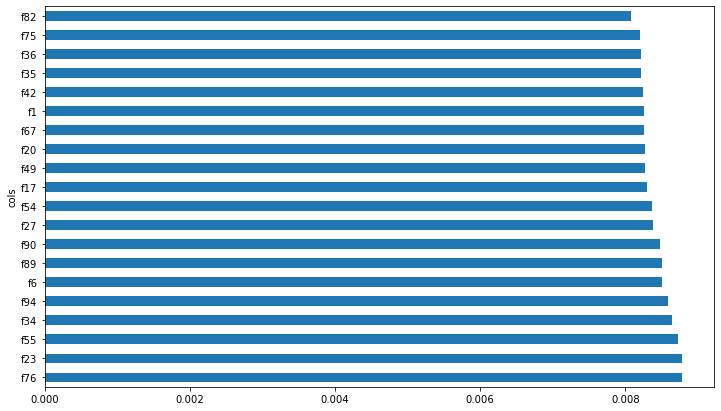

In [56]:
# borrowed from ch09 of fast.ai book
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(model, X)
fi[:10]

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[50:70])

In [54]:
fi.iloc[16]

cols         f93
imp     0.012798
Name: 93, dtype: object

Let's try removing any features with importance < 0.008.

In [65]:
to_keep = fi[fi.imp > 0.008].cols
len(to_keep)

71

In [66]:
X_imp = X[to_keep]

In [68]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBRegressor(
        tree_method='auto',
        booster='dart',
        n_estimators=400, 
        max_depth=3,
        learning_rate=0.1522, 
        subsample=1,
        random_state=42,
#         test_size=config.test_size,
        n_jobs=-1, 
        verbosity=1, 
    )
# model.fit(X_train, y_train)
# y_pred = model.predict(X_valid)
# rmse_orig = mean_squared_error(y_valid, y_pred)**0.5
# print(f"The rmse of the original validation set is {rmse_orig}")
# The rmse of the original validation set is 7.83147100378777

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


The rmse of the original validation set is 7.83147100378777


NameError: name 'config' is not defined

In [70]:
Xi_train, Xi_valid, yi_train, yi_valid = train_test_split(X_imp, y, test_size=0.2, random_state=42)
modeli = XGBRegressor(
        tree_method='auto',
        booster='dart',
        n_estimators=400, 
        max_depth=3,
        learning_rate=0.1522, 
        subsample=1,
        random_state=42,
#         test_size=config.test_size,
        n_jobs=-1, 
        verbosity=1, 
    )
# modeli.fit(Xi_train, yi_train)
# yi_pred = modeli.predict(Xi_valid)
# rmse_imp = mean_squared_error(yi_valid, yi_pred)**0.5
# print(f"The rmse of the important-features-only validation set is {rmse_imp}")
# The rmse of the important-features-only validation set is 7.833142176816611

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


The rmse of the important-features-only validation set is 7.833142176816611


In [32]:
# wandb.sklearn.plot_regressor(model, X_train, X_valid, y_train, y_valid,  model_name='RandomForestRegressor', )

So, cutting out ~30 features based on feature importance does *not* help.

In [72]:
to_keep = fi[fi.imp > 0.0075].cols
len(to_keep)

81

Let's try ~20 cuts.

In [73]:
X_imp = X[to_keep]
Xi_train, Xi_valid, yi_train, yi_valid = train_test_split(X_imp, y, test_size=0.2, random_state=42)
modeli = XGBRegressor(
        tree_method='auto',
        booster='dart',
        n_estimators=400, 
        max_depth=3,
        learning_rate=0.1522, 
        subsample=1,
        random_state=42,
#         test_size=config.test_size,
        n_jobs=-1, 
        verbosity=1, 
    )
modeli.fit(Xi_train, yi_train)
yi_pred = modeli.predict(Xi_valid)
rmse_imp = mean_squared_error(yi_valid, yi_pred)**0.5
print(f"The rmse of the important-features-only validation set is {rmse_imp}")
# The rmse of the important-features-only validation set is 7.833142176816611

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


The rmse of the important-features-only validation set is 7.831915960516926


Still not an improvement -- lets lose only ~10 features.

In [74]:
to_keep = fi[fi.imp > 0.007].cols
len(to_keep)

88

In [75]:
X_imp = X[to_keep]
Xi_train, Xi_valid, yi_train, yi_valid = train_test_split(X_imp, y, test_size=0.2, random_state=42)
modeli = XGBRegressor(
        tree_method='auto',
        booster='dart',
        n_estimators=400, 
        max_depth=3,
        learning_rate=0.1522, 
        subsample=1,
        random_state=42,
#         test_size=config.test_size,
        n_jobs=-1, 
        verbosity=1, 
    )
modeli.fit(Xi_train, yi_train)
yi_pred = modeli.predict(Xi_valid)
rmse_imp = mean_squared_error(yi_valid, yi_pred)**0.5
print(f"The rmse of the important-features-only validation set is {rmse_imp}")
# The rmse of the important-features-only validation set is 7.833928923238066

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


The rmse of the important-features-only validation set is 7.833928923238066


I can check later if <10 features being removed helps, but it seems to me that this is not a particularly fruitful approach: best to just leave the features as they are (i.e. don't subtract -- though adding is still on the table...)

# `cluster_columns` (for redundancy)

Let's try a `fastai` function, `cluster_columns`, which gives a sense of feature redundancies.

In [77]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

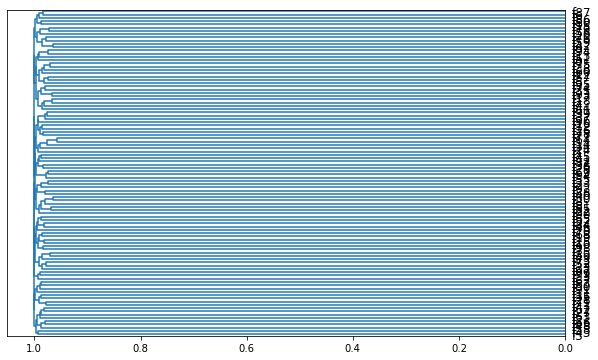

In [78]:
cluster_columns(X)

Insofar as splits further to the right are signs of redunancy, I don't think we have much -- which is consistent with the finding that the features are all fairly important.

# OOB Score
#todo 

# Predictions

In [44]:
y_pred = model.predict(X)

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [45]:
y_pred[:10]

array([7.5242977, 8.158392 , 4.832366 , 7.419939 , 6.553831 , 7.712717 ,
       7.8510847, 7.165042 , 5.162752 , 5.5137396], dtype=float32)

In [46]:
test_df = pd.read_csv(datapath/'test.csv', index_col='id', low_memory=False)

In [47]:
test_df.head()

f0   f1        f2        f3          f4        f5         f6  \
id                                                                           
250000  0.812665   15 -1.239120 -0.893251    295.5770  15.87120   23.04360   
250001  0.190344  131 -0.501361  0.801921     64.8866   3.09703  344.80500   
250002  0.919671   19 -0.057382  0.901419  11961.2000  16.39650  273.24000   
250003  0.860985   19 -0.549509  0.471799   7501.6000   2.80698   71.08170   
250004  0.313229   89  0.588509  0.167705   2931.2600   4.34986    1.57187   

              f7         f8       f9  ...       f90        f91       f92  \
id                                    ...                                  
250000  0.942256  29.898000  1.11394  ...  0.446389   -422.332  -1.44630   
250001  0.807194  38.421900  1.09695  ...  0.377179  10352.200  21.06270   
250002 -0.003300  37.940000  1.15222  ...  0.990140   3224.020  -2.25287   
250003  0.792136   0.395235  1.20157  ...  1.396880   9689.760  14.77150   
250004  1.118300   7.754630  1.16807  ...  0.862502   2693.350  44.18050   

            f93       f94        f95      f96       f97       f98       f99  
id                                                                           
250000  1.69075  1.059300  -3.010570  1.94664  0.529470  1.386950   8.78767  
250001  1.84351  0.251895   4.440570  1.90309  0.248534  0.863881  11.79390  
250002  1.55100 -0.559157  17.838600  1.83385  0.931796  2.336870   9.05400  
250003  1.41390  0.329272   0.802437  2.23251  0.893348  1.359470   4.84833  
250004  1.58020 -0.191021  26.253000  2.68238  0.361923  1.532800   3.70660  

[5 rows x 100 columns]

In [48]:
X_test = test_df[features] # this is just for naming consistency

In [49]:
y_test_preds = model.predict(X_test)

/home/sf/anaconda3/envs/tabular/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [50]:
sample_df = pd.read_csv(datapath/'sample_submission.csv')

In [51]:
sample_df.loc[:, 'loss'] = y_test_preds

In [52]:
sample_df.head()

id      loss
0  250000  8.155357
1  250001  4.386151
2  250002  7.510742
3  250003  7.391403
4  250004  7.604273

In [53]:
sample_df.to_csv('202108062038_XGBoost.csv', index=False)

In [51]:
# wandb.finish()